In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from analysis import collection, analysis, emg
import scipy as sp
import pandas as pd
import swifter
import umap.umap_ as umap

/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
channels = np.arange(2)
n_timepoints = 1070
timepoints = np.arange(n_timepoints)
n_targets = 12
target_numbers = range(1,n_targets+1)
n_blocks = 45
blocks = range(n_blocks)
n_subjects = 46
subjects = range(n_subjects)

multi_index = pd.MultiIndex.from_product([timepoints,target_numbers,blocks,subjects][::-1],names=["time", "target", "block","subject"][::-1])
print(multi_index.shape)
subject_traj_stacks = np.load("subject_traj_stacks.npy")
print(subject_traj_stacks.shape)
df = pd.DataFrame(subject_traj_stacks.reshape(-1,2),index=multi_index,columns=channels).dropna()
del subject_traj_stacks
print(df.shape)

(26578800,)
(46, 45, 12, 1070, 2)
(7820997, 2)


In [15]:
target_vecs = [collection.compute_target_vec_from_number(target_number) for target_number in range(1,13)]

def compute_reward(row):
    return np.linalg.norm(row - target_vecs[row.name[2] - 1])

def array_map(x,f):
    return np.array(list(map(f, x)))

In [16]:
df["reward"] = df.swifter.apply(compute_reward,axis='columns',result_type="expand")

Pandas Apply: 100%|██████████| 7820997/7820997 [02:50<00:00, 45781.11it/s]


In [17]:
trial_means = df.groupby(level=["subject", "block", "target"]).mean()

target
1     Axes(0.125,0.11;0.775x0.77)
2     Axes(0.125,0.11;0.775x0.77)
3     Axes(0.125,0.11;0.775x0.77)
4     Axes(0.125,0.11;0.775x0.77)
5     Axes(0.125,0.11;0.775x0.77)
6     Axes(0.125,0.11;0.775x0.77)
7     Axes(0.125,0.11;0.775x0.77)
8     Axes(0.125,0.11;0.775x0.77)
9     Axes(0.125,0.11;0.775x0.77)
10    Axes(0.125,0.11;0.775x0.77)
11    Axes(0.125,0.11;0.775x0.77)
12    Axes(0.125,0.11;0.775x0.77)
dtype: object

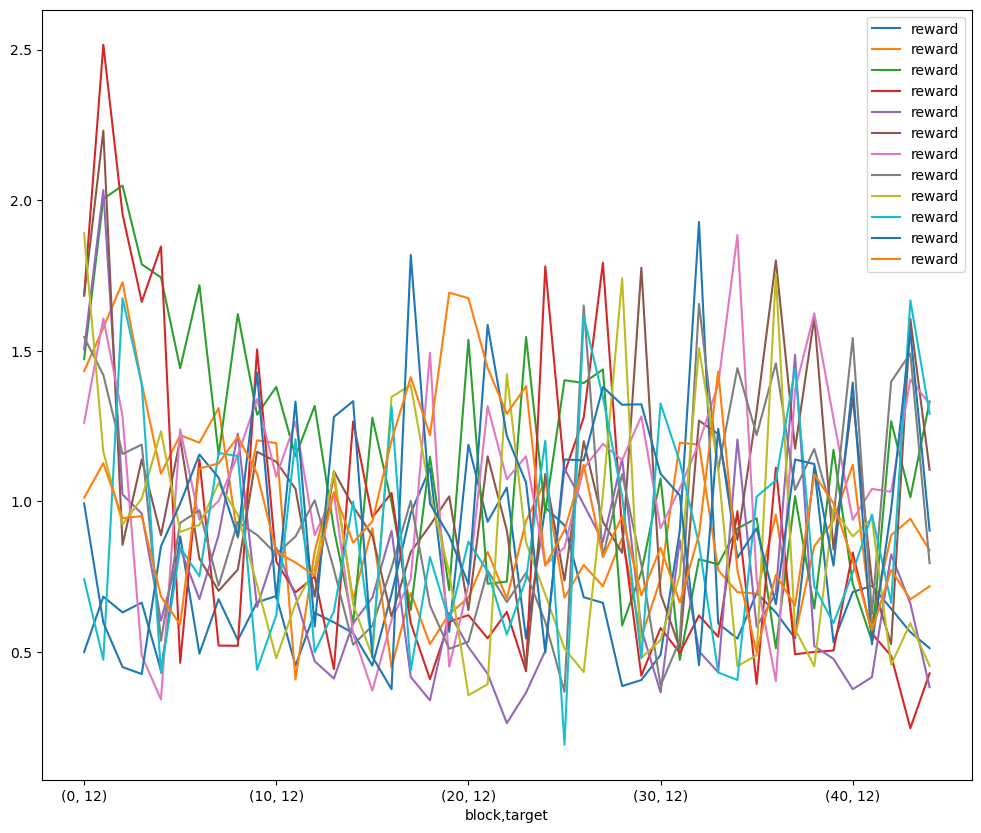

In [35]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
trial_means.xs(8, level="subject").groupby("target").plot(y="reward", ax=ax)

In [36]:
df.to_pickle("trajectory_dataframe.pkl")